In [14]:
#Importing necessary libraries and packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

### Code for on-board ArUco marker detection. Each marker has unique ID assigned which can be programmed for various detections. Furthermore, a red box indicates the upper-left corner for each marker which can be used to indicate direction.

In [15]:
image_path = 'C:/Users/tabri/Desktop/Drone/Code/marker6.png'
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not loaded. Check the file path.")
else:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray_image = cv2.convertScaleAbs(gray_image, alpha=1.5, beta=0)

    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
    parameters = cv2.aruco.DetectorParameters()

    corners, ids, rejected_img_points = cv2.aruco.detectMarkers(gray_image, aruco_dict, parameters=parameters)

    if ids is not None:
        print(f"Detected marker IDs: {ids.flatten()}")
        print(f"Corners of detected markers: {corners}")

        for i, corner in enumerate(corners):
            marker_id = ids[i][0]
            corner = corner.reshape((4, 2))

            top_left_corner = tuple(map(int, corner[0]))
            box_size = 10  # Size of the red box
            cv2.rectangle(image, 
                          (top_left_corner[0] - box_size, top_left_corner[1] - box_size), 
                          (top_left_corner[0] + box_size, top_left_corner[1] + box_size), 
                          (0, 0, 255), -1)  # Red filled box

            for j in range(4):
                start_point = tuple(map(int, corner[j]))
                end_point = tuple(map(int, corner[(j + 1) % 4]))
                cv2.line(image, start_point, end_point, (0, 255, 0), 4)

            marker_center = np.mean(corner, axis=0).astype(int)
            cv2.putText(image, f'ID: {marker_id}', (marker_center[0] - 20, marker_center[1] - 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    else:
        print("No markers detected.")


Detected marker IDs: [ 98  40  23 203 124  62]
Corners of detected markers: (array([[[261., 224.],
        [299., 224.],
        [301., 262.],
        [263., 263.]]], dtype=float32), array([[[198., 286.],
        [234., 286.],
        [236., 325.],
        [198., 324.]]], dtype=float32), array([[[142., 141.],
        [179., 141.],
        [180., 177.],
        [144., 178.]]], dtype=float32), array([[[ 31., 102.],
        [ 66., 100.],
        [ 67., 136.],
        [ 30., 137.]]], dtype=float32), array([[[274.,  99.],
        [274., 134.],
        [238., 137.],
        [238., 102.]]], dtype=float32), array([[[ 93., 254.],
        [ 59., 255.],
        [ 57., 220.],
        [ 92., 220.]]], dtype=float32))


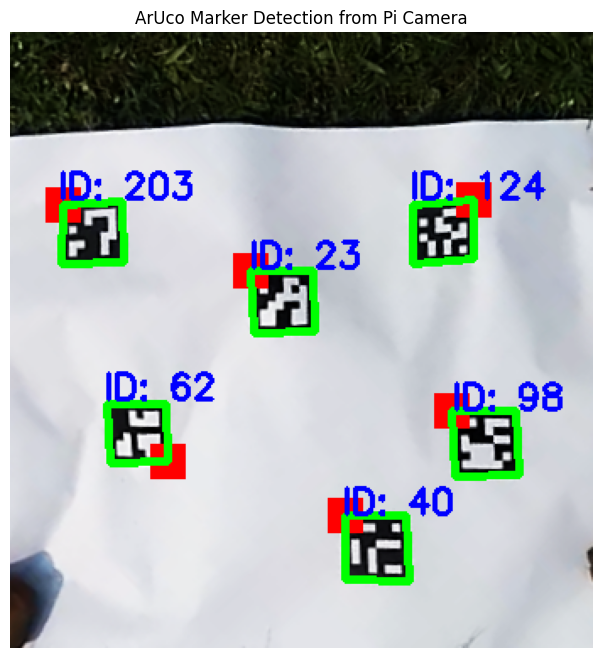

In [16]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("ArUco Marker Detection from Pi Camera")
plt.show()


#### This code defines a PID controller class for adjusting control variables based on proportional, integral, and derivative gains. It simulates a drone’s initial 3D position, aiming to reach a target marker at the origin, using a defined time step (dt) for position updates.

In [17]:
class PID:
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        self.Kp = Kp  # Proportional gain
        self.Ki = Ki  # Integral gain
        self.Kd = Kd  # Derivative gain
        self.setpoint = setpoint
        self.integral = 0
        self.previous_error = 0

    def update(self, current_value, dt):
        error = self.setpoint - current_value
        P = self.Kp * error
        self.integral += error * dt
        I = self.Ki * self.integral
        D = self.Kd * (error - self.previous_error) / dt
        self.previous_error = error
        return P + I + D

drone_position = np.array([5.0, 9.0, 10.0])
marker_position = np.array([0.0, 0.0, 0.0])

dt = 0.1


### Initializion of separate PID controllers for the X, Y, and Z axis using specified Kp, Ki, and Kd values, with each setpoint set to the target marker's position on that axis.

In [18]:
Kp, Ki, Kd = 0.6, 0.3, 0.2  # These values can be tuned as needed

pid_x = PID(Kp, Ki, Kd, setpoint=marker_position[0])
pid_y = PID(Kp, Ki, Kd, setpoint=marker_position[1])
pid_z = PID(Kp, Ki, Kd, setpoint=marker_position[2])


#### Simulation of a drone adjusting its position toward a target using PID control over 100 steps. At each step, control adjustments are applied to update the drone's X, Y, and Z positions, and the loop stops early if the drone is close enough to the target. Positions are stored for potential plotting.

In [19]:
# Simulation loop to correct the drone's path
positions = [drone_position.copy()]

for i in range(100):
    control_x = pid_x.update(drone_position[0], dt)
    control_y = pid_y.update(drone_position[1], dt)
    control_z = pid_z.update(drone_position[2], dt)

    drone_position[0] += control_x * dt
    drone_position[1] += control_y * dt
    drone_position[2] += control_z * dt

    positions.append(drone_position.copy())

    if np.linalg.norm(drone_position - marker_position) < 0.01:
        print("Drone has reached the target")
        break

positions = np.array(positions)


#### Plotting of the drone's X, Y, and Z positions over time steps, showing its descent path.

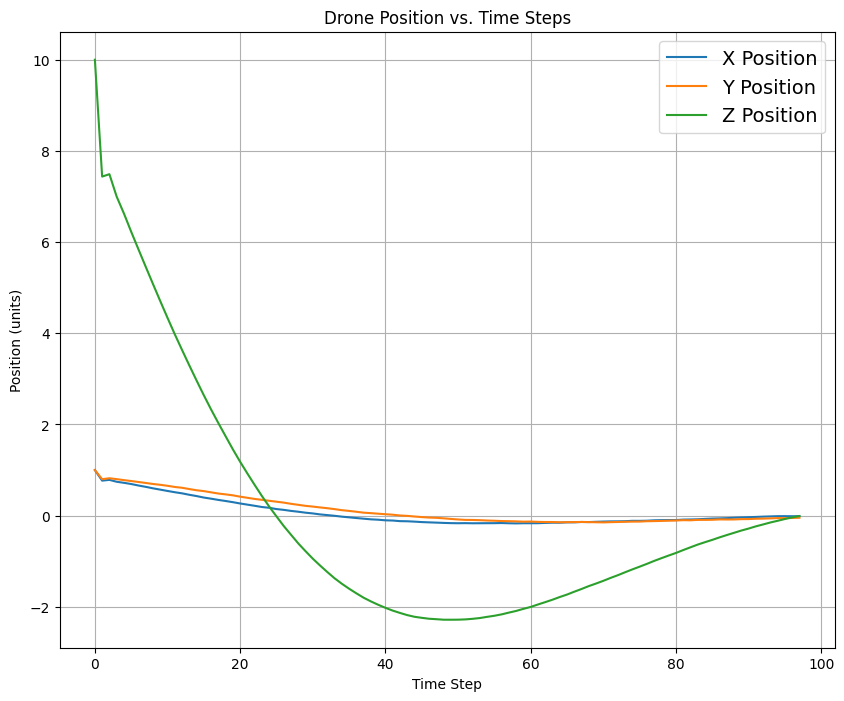

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.plot(positions[:, 0], label='X Position')
plt.plot(positions[:, 1], label='Y Position')
plt.plot(positions[:, 2], label='Z Position')

plt.xlabel('Time Step')
plt.ylabel('Position (units)')
plt.title('Drone Position vs. Time Steps')
plt.legend(fontsize=14)  # Adjust the font size here
plt.grid()
plt.show()



#### Simulating a drone’s 3D path with random noise to mimic real-world drift, then uses PID control to correct its course over 100 steps, stopping when near the target. The resulting path, including start and target points

In [21]:
# Random perturbations in the drone's initial path to make the correction more visible
np.random.seed(42)

drone_position = np.array([1.0, 1.0, 10.0])  # Initial position (X, Y, Z)
positions = [drone_position.copy()]

for i in range(100): 
    noise = np.random.uniform(-0.05, 0.05, size=3)

    control_x = pid_x.update(drone_position[0], dt)
    control_y = pid_y.update(drone_position[1], dt)
    control_z = pid_z.update(drone_position[2], dt)

    drone_position[0] += (control_x + noise[0]) * dt
    drone_position[1] += (control_y + noise[1]) * dt
    drone_position[2] += (control_z + noise[2]) * dt

    positions.append(drone_position.copy())

    if np.linalg.norm(drone_position - marker_position) < 0.05:
        print("Drone has reached the target")
        break




Drone has reached the target


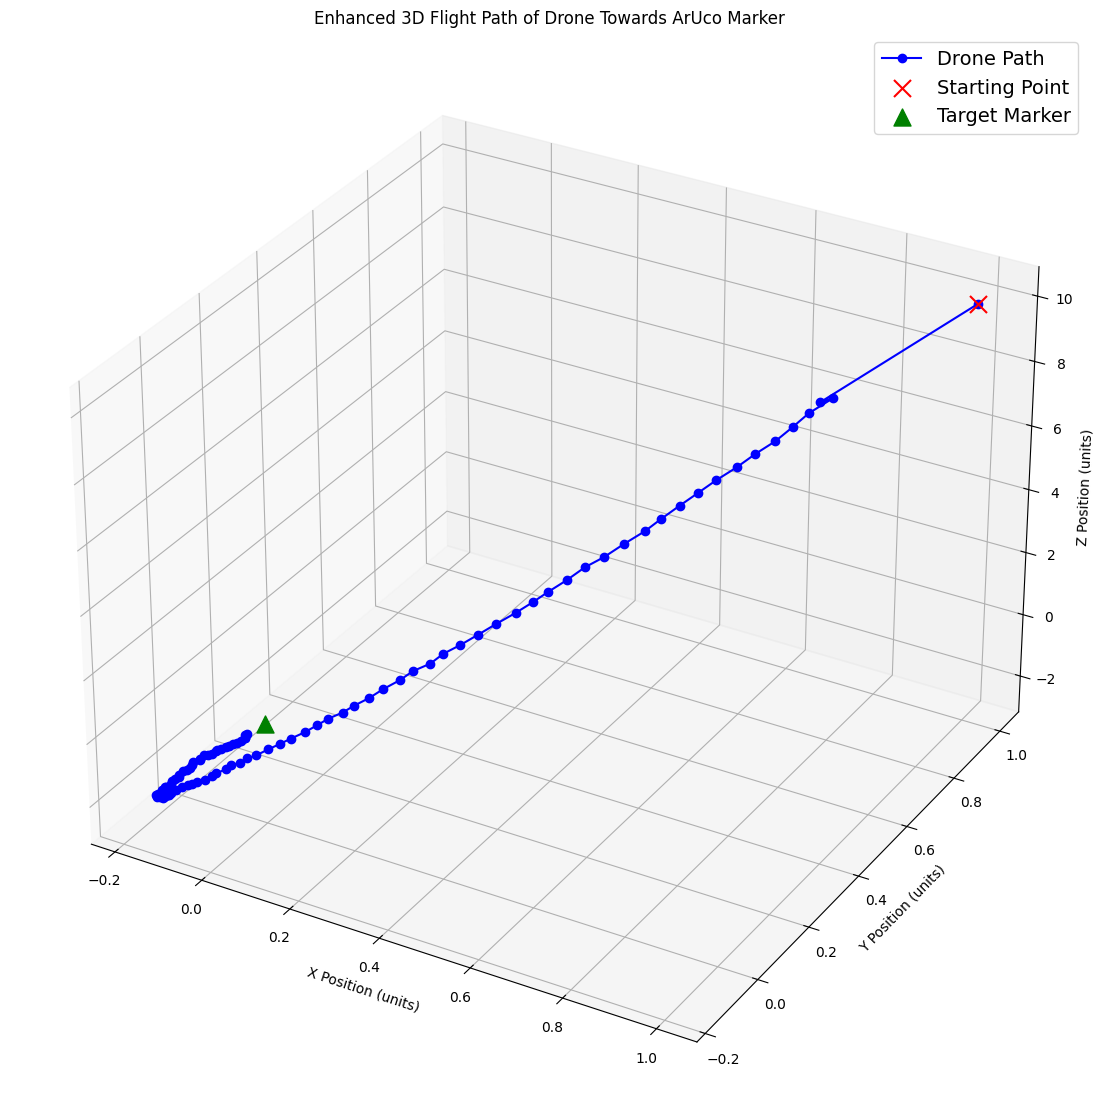

In [24]:
positions = np.array(positions)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Drone Path', color='b', marker='o', linestyle='-')

ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='r', s=150, label='Starting Point', marker='x')
ax.scatter(marker_position[0], marker_position[1], marker_position[2], color='g', s=150, label='Target Marker', marker='^')

ax.set_xlabel('X Position (units)')
ax.set_ylabel('Y Position (units)')
ax.set_zlabel('Z Position (units)')
ax.set_title('Enhanced 3D Flight Path of Drone Towards ArUco Marker')

ax.legend(fontsize=14)
ax.grid()

plt.show()